<a href="https://colab.research.google.com/github/dxdyd/Face-recognition-ML/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install face_recognition

!pip install cmake
!pip install dlib
!sudo apt-get update
!sudo apt-get install -y build-essential cmake libopenblas-dev liblapack-dev libx11-dev libgtk-3-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=84a2978bcbcb309ecd5869473e4d83059ec0b5a23d2b0bc35a4097a335d5d943
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,204 kB]
Hit:8 https

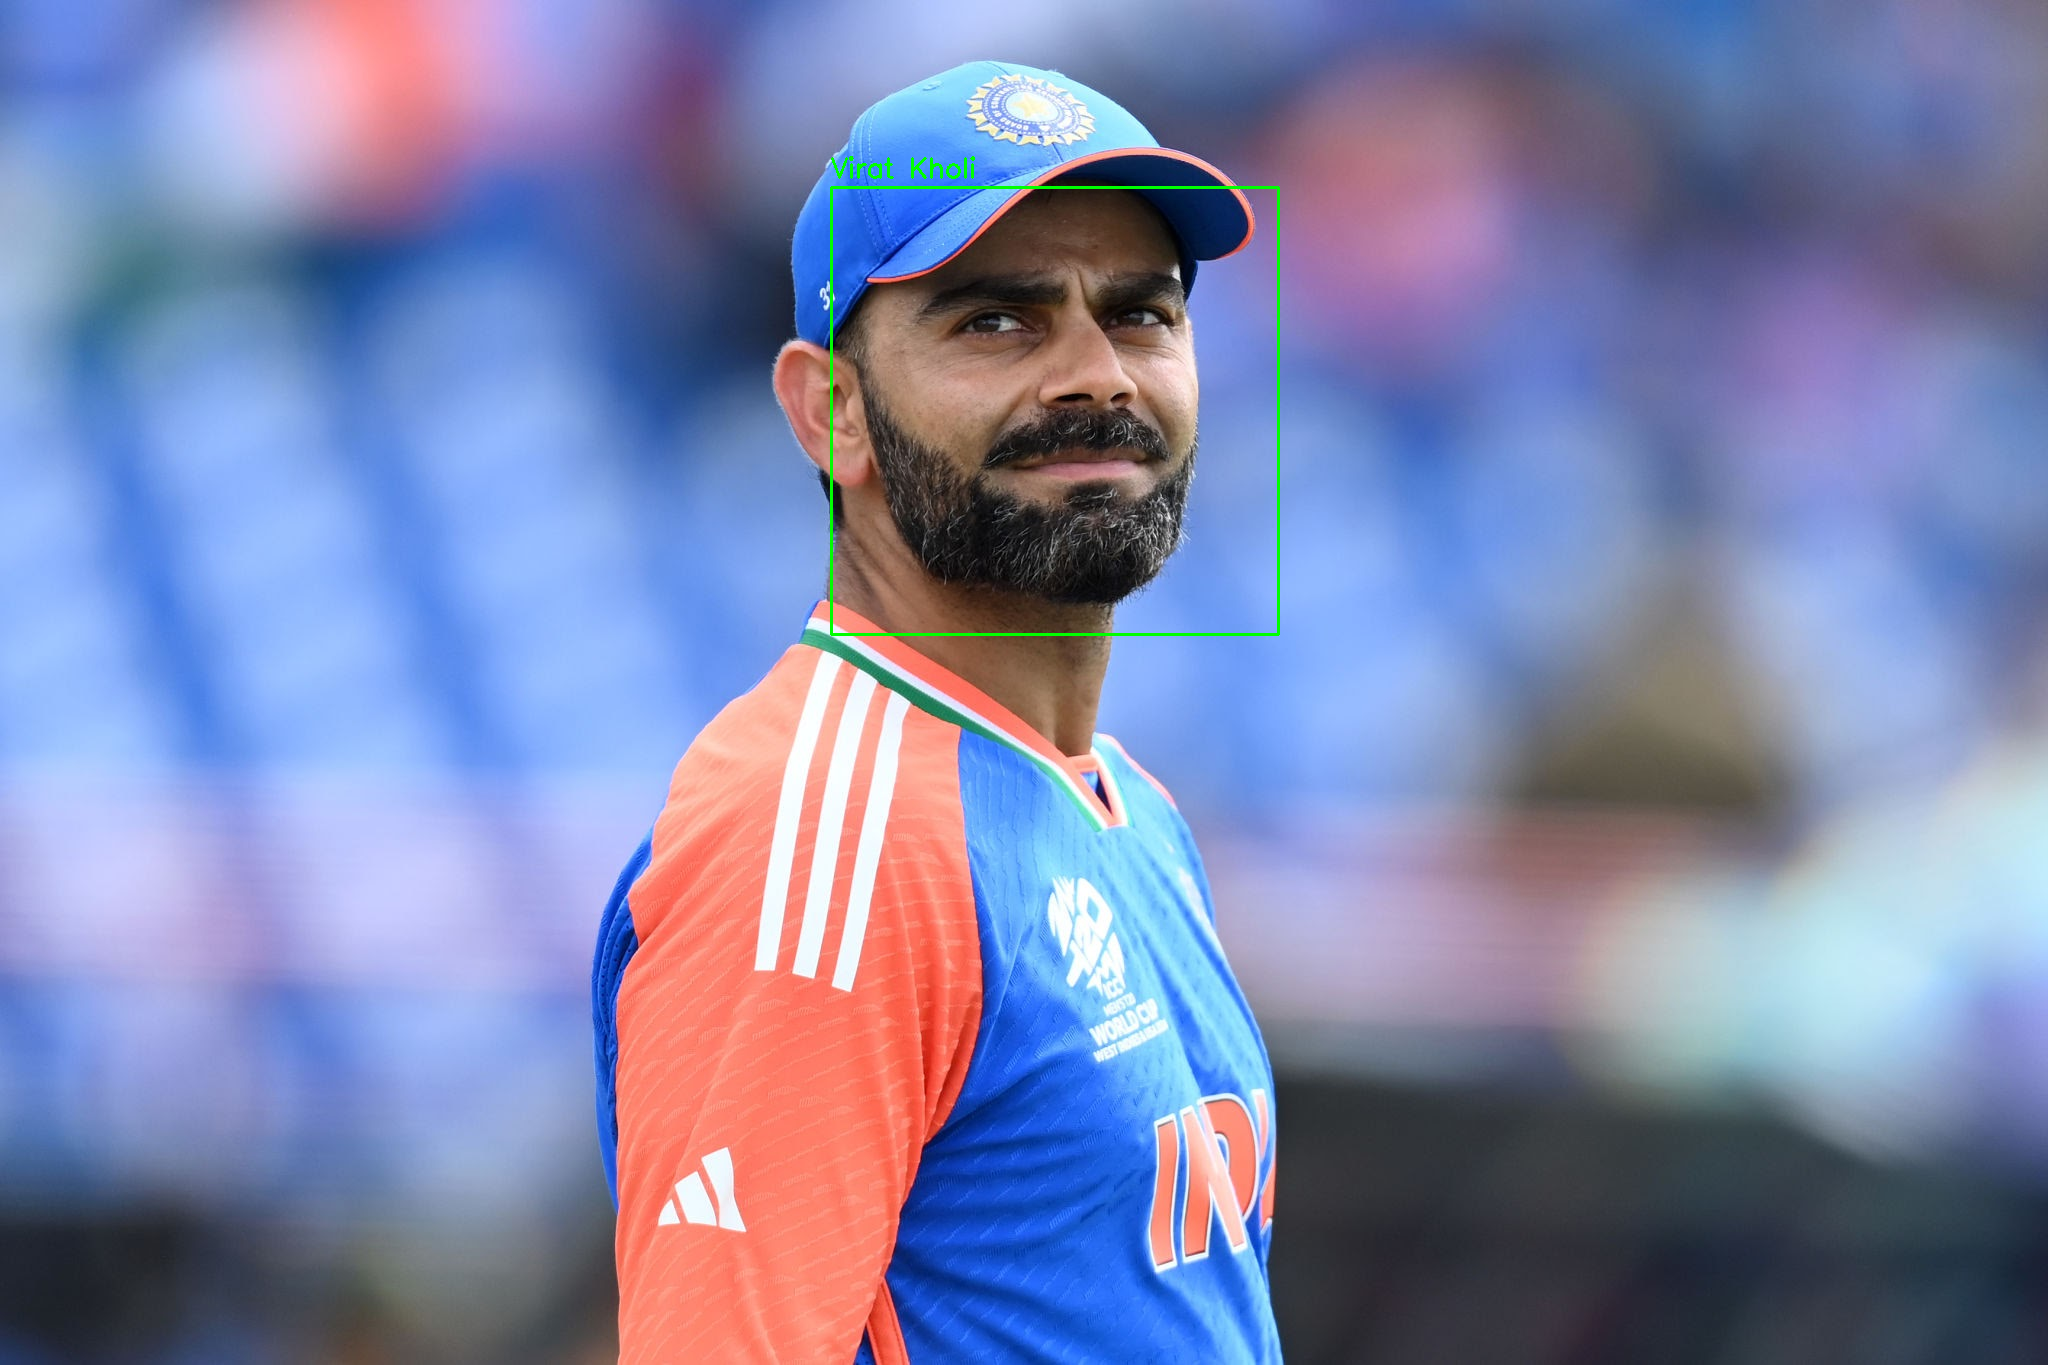

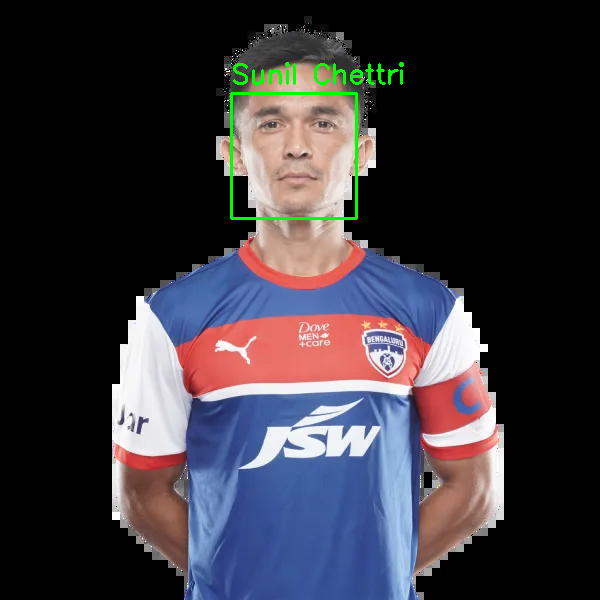

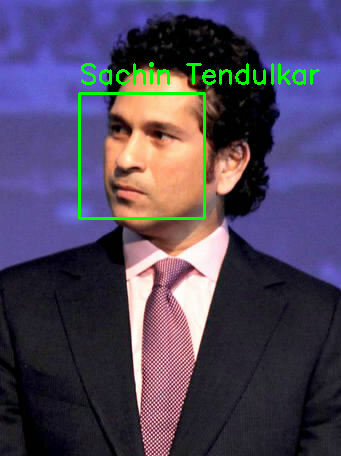

Model Accuracy: 0.00%


In [15]:

from google.colab.patches import cv2_imshow
import os
import cv2
import dlib
import numpy as np
from sklearn.metrics import accuracy_score
!pip install opencv-python dlib face_recognition --no-binary :all:

!pip install opencv-python dlib numpy scikit-learn


# Path to the dataset
folder_path = '/content/drive/MyDrive/Data/data_set/Players'

# Load Dlib's pre-trained face detection and recognition models
detector = dlib.get_frontal_face_detector()
predictor_path = '/content/drive/MyDrive/Data/dat file/shape_predictor_68_face_landmarks (1).dat'
face_rec_model_path = '/content/drive/MyDrive/Data/dat file/dlib_face_recognition_resnet_model_v1.dat'
shape_predictor = dlib.shape_predictor(predictor_path)
face_rec_model = dlib.face_recognition_model_v1(face_rec_model_path)

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            labels.append(os.path.splitext(filename)[0])
    return images, labels

images, labels = load_images_from_folder(folder_path)

def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    return faces

def encode_faces(images):
    encodings = []
    for image in images:
        faces = detect_faces(image)
        for face in faces:
            shape = shape_predictor(image, face)
            encoding = np.array(face_rec_model.compute_face_descriptor(image, shape))
            encodings.append(encoding)
    return encodings

known_encodings = encode_faces(images)
known_labels = labels

def recognize_faces(image, known_encodings, known_labels):
    faces = detect_faces(image)
    names = []

    for face in faces:
        shape = shape_predictor(image, face)
        encoding = np.array(face_rec_model.compute_face_descriptor(image, shape))

        matches = np.linalg.norm(known_encodings - encoding, axis=1)
        best_match_index = np.argmin(matches)
        name = "Unknown"
        if matches[best_match_index] < 0.6:  # Threshold for face matching
            name = known_labels[best_match_index]

        names.append(name)
    return faces, names

# Example usage:
for image in images:
    faces, names = recognize_faces(image, known_encodings, known_labels)
    for (face, name) in zip(faces, names):
        x, y, w, h = (face.left(), face.top(), face.width(), face.height())
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2_imshow(image) # Use cv2_imshow instead of cv2.imshow
    cv2.waitKey(0)
cv2.destroyAllWindows()

def evaluate_model(test_images, test_labels, known_encodings, known_labels):
    predictions = []
    true_labels = []

    for image, label in zip(test_images, test_labels):
        faces, names = recognize_faces(image, known_encodings, known_labels)
        if len(names) > 0:
            predictions.append(names[0])
        else:
            predictions.append("Unknown")
        true_labels.append(label)

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Split your data into training and testing sets
train_images, train_labels = images[:int(0.8*len(images))], labels[:int(0.8*len(labels))]
test_images, test_labels = images[int(0.8*len(images)):], labels[int(0.8*len(labels)):]

# Train your model
known_encodings = encode_faces(train_images)
known_labels = train_labels

# Evaluate your model
accuracy = evaluate_model(test_images, test_labels, known_encodings, known_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")